## Import dependent libraries

In [2]:
from pandas import read_csv
from matplotlib import pyplot
import math
from numpy import concatenate, array
from pandas import DataFrame
from pandas import concat
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Model, model_from_json
from keras.layers import Input
import keras
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.layers.core import Activation
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.externals import joblib
import tensorflow as tf
from keras.utils import plot_model


Using TensorFlow backend.


## Load dataset

In [3]:
dataset = read_csv('music_data.csv', header=0)
values = dataset.values
values = values.astype('float32')

## Specify columns to plot

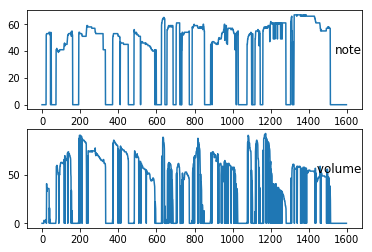

In [4]:
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1


pyplot.show()

## Convert series to supervised learning

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [6]:
dataset = read_csv('music_data.csv', header=1)
values = dataset.values
values = values.astype('float32')

## Scale Data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

joblib.dump(scaler, 'scaler.pkl')
print('Saved scaler to disk.')
# frame as supervised learning

Saved scaler to disk.


In [8]:
# specify the number of lag hours
n_hours = 256
n_features = 2
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
# print(reframed)

In [9]:
values = reframed.values
n_train_hours = 1000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features

In [10]:
train_X = train[:, :n_obs]
# print(train_X)

train_y_notes = train[:, -n_features]
train_y_volume = train[:, -n_features -1]
train_y_length = train[:, -n_features -2]

test_X = test[:, :n_obs]
# print(test_X)
test_y_notes = test[:, -n_features]
test_y_volume = test[:, -n_features -1]
test_y_length = test[:, -n_features -2]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
# print(train_X[0:10])

test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y_notes.shape, test_X.shape, test_y_notes.shape)

(1000, 256, 2) (1000,) (341, 256, 2) (341,)


In [11]:
def split_left(x):
    x = x[:,0:int(n_hours/2)]
    print(x)
    return x

def split_right(x):
    x = x[:,int(n_hours/2):]
    print(x)
    return x

def split_shape(input_shape):
    return (input_shape[0], int(input_shape[1]/2), input_shape[2])

In [12]:
visible = Input(name='input', shape=(train_X.shape[1], train_X.shape[2]))

left_input_lambda = keras.layers.Lambda(split_left,
                 output_shape=split_shape)(visible)


right_input_lambda = keras.layers.Lambda(split_right,
                 output_shape=split_shape)(visible)

Tensor("lambda_1/strided_slice:0", shape=(?, 128, 2), dtype=float32)
Tensor("lambda_2/strided_slice:0", shape=(?, 128, 2), dtype=float32)


In [21]:
branch_input_size = int(n_hours)
branch_output_size = int(n_hours/2)
print(branch_input_size)
print(branch_output_size)

256
128


In [22]:

hidden1 = LSTM(branch_input_size, return_sequences=True)(left_input_lambda)
batchNorm1 = BatchNormalization()(hidden1)
dropout1 = Dropout(0.5)(batchNorm1)

hidden11 = LSTM(branch_output_size, return_sequences=True)(dropout1)

In [23]:
# new_model
hidden_A = LSTM(branch_input_size, return_sequences=True)(right_input_lambda)
batchNorm_A = BatchNormalization()(hidden_A)
dropout_A = Dropout(0.5)(batchNorm_A)

hidden_AA = LSTM(branch_output_size, return_sequences=True)(dropout_A)

In [26]:
concat = keras.layers.concatenate([hidden11, hidden_AA])
tdd = keras.layers.TimeDistributed(Dense(128))(concat)
hidden_Z = LSTM(branch_input_size)(tdd)

output_notes = Dense(1, activation='sigmoid', name='output_notes')(hidden_Z)
output_volume = Dense(1, activation='sigmoid', name='output_volume')(hidden_Z)
# output_length = Dense(1, activation='sigmoid', name='output_length')(hidden_Z)

model = Model(inputs=[visible], outputs=[
                                         output_notes, 
                                         output_volume, 
#                                          output_length
                                        ])

In [27]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

callback_list = [reduce_lr]

optimizer = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='mae', optimizer=optimizer)
# model.summary()

In [28]:
import pydot
import graphviz
plot_model(model, to_file='model.png')


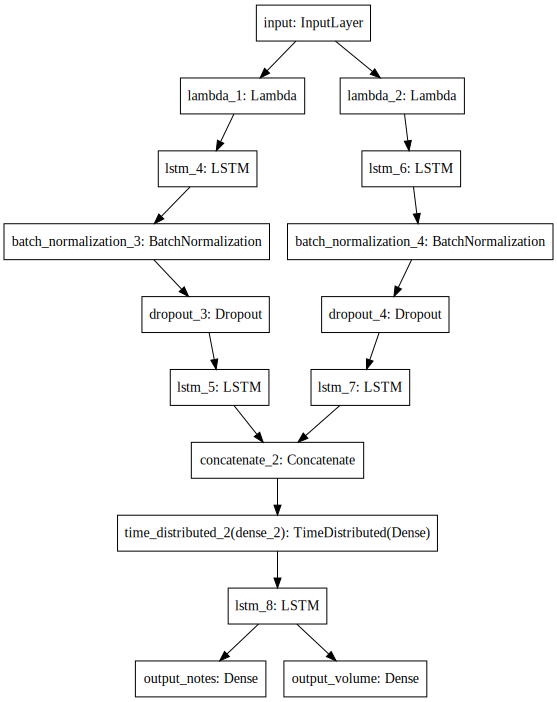

In [29]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
history = model.fit(
            {'input': train_X},
            {
                'output_notes': train_y_notes, 
                'output_volume': train_y_volume, 
#                 'output_length': train_y_length
            },
            validation_data=({'input': test_X},
                             {
                                 'output_notes': test_y_notes, 
                                 'output_volume': test_y_volume, 
#                                  'output_length': test_y_length
                             }), 
            verbose=2,
            shuffle=False,
            epochs=150, 
            batch_size=100)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

###### 